In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib as plt
import tensorflow as tf
from tqdm import tqdm
import utils
import seaborn as sns

# Import data 
game_state_20, game_state_40, game_state_60, game_state_80, game_state_100 = utils.get_inputs()

2023-11-23 01:11:13.480429: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-23 01:11:13.525190: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-23 01:11:13.525220: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-23 01:11:13.526955: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-23 01:11:13.534401: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-23 01:11:13.534775: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
# Prepare training, validation, and test datasets for 20% game time

train_frac = 0.8
valid_frac = 0.1

train_set = game_state_20.sample(frac = 0.8)
remaining_set = game_state_20.drop(train_set.index)
valid_set = remaining_set.sample(frac = valid_frac / (1 - train_frac))
test_set = remaining_set.drop(valid_set.index)

# Separate wins
train_wins = train_set.pop('blueWin')
valid_wins = valid_set.pop('blueWin')
test_wins = test_set.pop('blueWin')

print(game_state_20.shape, train_set.shape, valid_set.shape, test_set.shape)


(64556, 36) (51645, 35) (6456, 35) (6455, 35)


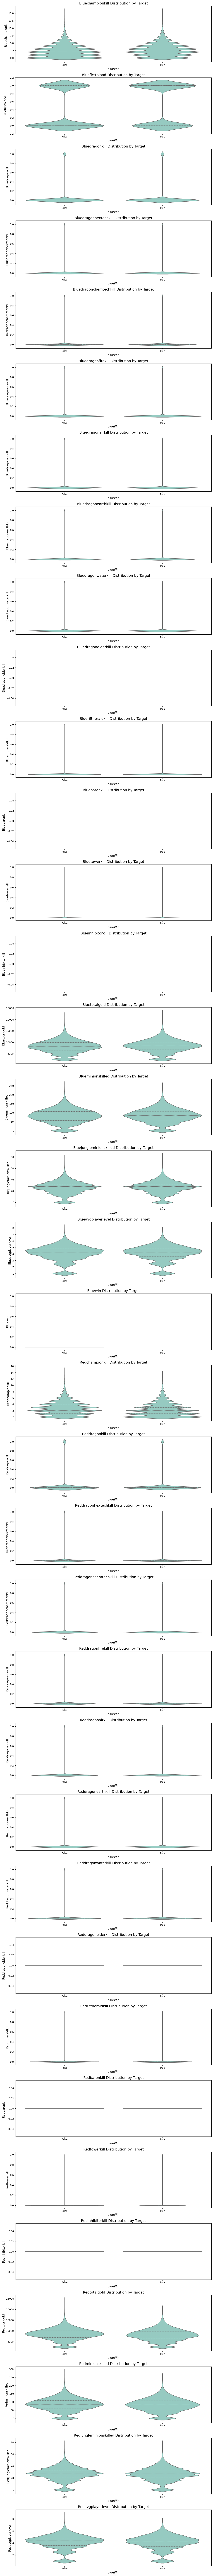

In [13]:
# Visualize data

plot_data = game_state_20

cont_cols = [f for f in plot_data.columns if plot_data[f].dtype != '0']
n_rows = len(cont_cols)

fig, axs = plt.pyplot.subplots(n_rows, 1, figsize=(12, 4 * n_rows))

for i, col in enumerate(cont_cols):
    sns.violinplot(x='blueWin', y=col, data=plot_data, ax=axs[i], inner="quart", bw_adjust = 1.1)
    axs[i].set_title(f'{col.title()} Distribution by Target', fontsize=14)
    axs[i].set_xlabel('blueWin', fontsize=12)
    axs[i].set_ylabel(col.title(), fontsize=12)
    #sns.despine()

fig.tight_layout()

plt.pyplot.show()

In [ ]:
# Feature engineering

In [4]:
# Convert dataframes to tensors
train_data = tf.convert_to_tensor(train_set)
train_labels = tf.convert_to_tensor(train_wins)

valid_data = tf.convert_to_tensor(valid_set)
valid_labels = tf.convert_to_tensor(valid_wins)

#train_data = train_data[..., tf.newaxis]
#valid_data = valid_data[..., tf.newaxis]
# Define batches

def get_batch(data, labels, batch_size):
    return tf.data.Dataset.from_tensor_slices((data, labels)).batch(batch_size)

train_batched = get_batch(train_data, train_labels, 64)
valid_batched = get_batch(valid_data, valid_labels, 64)

print(tf.shape(train_data), tf.shape(train_labels))


tf.Tensor([51645    35], shape=(2,), dtype=int32) tf.Tensor([51645], shape=(1,), dtype=int32)


In [5]:
# Define model
class DNNModel(tf.keras.Model):

    def __init__(self):
        super().__init__()
        # Single dense layer
        self.layer1 = tf.keras.layers.Dense(35, activation='relu')
        self.layer2 = tf.keras.layers.Dense(1)
        
    def call(self, input):
        input = self.layer1(input)
        return self.layer2(input)

model = DNNModel()

# Choose optimizer and loss function
optimizer = tf.keras.optimizers.Adam()
loss_func = tf.keras.losses.CategoricalCrossentropy()

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.CategoricalAccuracy(name='train_accuracy')

valid_loss = tf.keras.metrics.Mean(name='validation_loss')
valid_accuracy = tf.keras.metrics.CategoricalAccuracy(name='validation_accuracy')


# Define training step
@tf.function
def train_step(match_states, outcomes):
    with tf.GradientTape() as tape:  
        predictions = tf.squeeze(model(match_states))
        loss = loss_func(outcomes, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_accuracy(outcomes, predictions)

# Define testing step
@tf.function
def test_step(match_states, outcomes):
    predictions = tf.squeeze(model(match_states))
    loss = loss_func(outcomes, predictions)

    valid_loss(loss)
    valid_accuracy(outcomes, predictions)

# Set output
output_dir = './output'
output_prefix = os.path.join(output_dir, "DNN_2l_20")


# Run
EPOCHS = 100

for epoch in tqdm(range(EPOCHS)):
    train_loss.reset_states()
    train_accuracy.reset_states()
    valid_loss.reset_states()
    valid_accuracy.reset_states()

    for match_states, outcomes in train_batched:
        train_step(match_states, outcomes)

    for match_states, outcomes in valid_batched:
        test_step(match_states, outcomes)

    if epoch % 10 == 0:
        model.save_weights(output_prefix)

    print(
    f'Epoch {epoch + 1}, '
    f'Loss: {train_loss.result()}, '
    f'Accuracy: {train_accuracy.result()}, '
    f'Validation Loss: {valid_loss.result()}, '
    f'Validation Accuracy: {valid_accuracy.result()}'
  )

model.save_weights(output_prefix)

  1%|▍                                          | 1/100 [00:02<03:38,  2.21s/it]

Epoch 1, Loss: 135.4866485595703, Accuracy: 0.012391573749482632, Validation Loss: 133.3809051513672, Validation Accuracy: 0.0


  2%|▊                                          | 2/100 [00:02<02:13,  1.37s/it]

Epoch 2, Loss: 135.02342224121094, Accuracy: 0.01610904559493065, Validation Loss: 133.60118103027344, Validation Accuracy: 0.0


  3%|█▎                                         | 3/100 [00:03<01:46,  1.10s/it]

Epoch 3, Loss: 134.68026733398438, Accuracy: 0.01610904559493065, Validation Loss: 132.9066619873047, Validation Accuracy: 0.009900989942252636


  4%|█▋                                         | 4/100 [00:04<01:33,  1.03it/s]

Epoch 4, Loss: 134.41465759277344, Accuracy: 0.014869888313114643, Validation Loss: 132.76626586914062, Validation Accuracy: 0.009900989942252636


  5%|██▏                                        | 5/100 [00:05<01:25,  1.11it/s]

Epoch 5, Loss: 134.217041015625, Accuracy: 0.013630731031298637, Validation Loss: 132.36080932617188, Validation Accuracy: 0.009900989942252636


  6%|██▌                                        | 6/100 [00:06<01:20,  1.16it/s]

Epoch 6, Loss: 134.0821075439453, Accuracy: 0.012391573749482632, Validation Loss: 132.57261657714844, Validation Accuracy: 0.009900989942252636


  7%|███                                        | 7/100 [00:06<01:17,  1.20it/s]

Epoch 7, Loss: 133.9376220703125, Accuracy: 0.012391573749482632, Validation Loss: 132.12342834472656, Validation Accuracy: 0.009900989942252636


  8%|███▍                                       | 8/100 [00:07<01:15,  1.23it/s]

Epoch 8, Loss: 133.88865661621094, Accuracy: 0.012391573749482632, Validation Loss: 132.1063690185547, Validation Accuracy: 0.009900989942252636


  9%|███▊                                       | 9/100 [00:08<01:13,  1.24it/s]

Epoch 9, Loss: 133.94210815429688, Accuracy: 0.011152416467666626, Validation Loss: 132.360107421875, Validation Accuracy: 0.009900989942252636


 10%|████▏                                     | 10/100 [00:09<01:11,  1.26it/s]

Epoch 10, Loss: 134.04368591308594, Accuracy: 0.013630731031298637, Validation Loss: 132.0482940673828, Validation Accuracy: 0.009900989942252636


 11%|████▌                                     | 11/100 [00:09<01:10,  1.26it/s]

Epoch 11, Loss: 133.79043579101562, Accuracy: 0.013630731031298637, Validation Loss: 132.0484161376953, Validation Accuracy: 0.009900989942252636


 12%|█████                                     | 12/100 [00:10<01:09,  1.26it/s]

Epoch 12, Loss: 133.70339965820312, Accuracy: 0.013630731031298637, Validation Loss: 132.07205200195312, Validation Accuracy: 0.009900989942252636


 13%|█████▍                                    | 13/100 [00:11<01:08,  1.27it/s]

Epoch 13, Loss: 133.68862915039062, Accuracy: 0.012391573749482632, Validation Loss: 131.8603515625, Validation Accuracy: 0.009900989942252636


 14%|█████▉                                    | 14/100 [00:12<01:07,  1.27it/s]

Epoch 14, Loss: 133.67669677734375, Accuracy: 0.012391573749482632, Validation Loss: 131.9541473388672, Validation Accuracy: 0.009900989942252636


 15%|██████▎                                   | 15/100 [00:13<01:06,  1.28it/s]

Epoch 15, Loss: 133.60824584960938, Accuracy: 0.00991325918585062, Validation Loss: 131.8675537109375, Validation Accuracy: 0.009900989942252636


 16%|██████▋                                   | 16/100 [00:13<01:05,  1.28it/s]

Epoch 16, Loss: 133.6483917236328, Accuracy: 0.006195786874741316, Validation Loss: 131.9732208251953, Validation Accuracy: 0.009900989942252636


 17%|███████▏                                  | 17/100 [00:14<01:04,  1.28it/s]

Epoch 17, Loss: 133.59808349609375, Accuracy: 0.008674101904034615, Validation Loss: 131.93165588378906, Validation Accuracy: 0.009900989942252636


 18%|███████▌                                  | 18/100 [00:15<01:03,  1.29it/s]

Epoch 18, Loss: 133.6345977783203, Accuracy: 0.0074349441565573215, Validation Loss: 131.82086181640625, Validation Accuracy: 0.009900989942252636


 19%|███████▉                                  | 19/100 [00:16<01:02,  1.29it/s]

Epoch 19, Loss: 133.6363067626953, Accuracy: 0.0074349441565573215, Validation Loss: 131.9536895751953, Validation Accuracy: 0.009900989942252636


 20%|████████▍                                 | 20/100 [00:16<01:01,  1.29it/s]

Epoch 20, Loss: 135.1437530517578, Accuracy: 0.011152416467666626, Validation Loss: 133.34471130371094, Validation Accuracy: 0.009900989942252636


 21%|████████▊                                 | 21/100 [00:17<01:01,  1.29it/s]

Epoch 21, Loss: 134.42642211914062, Accuracy: 0.00991325918585062, Validation Loss: 132.1162872314453, Validation Accuracy: 0.009900989942252636


 22%|█████████▏                                | 22/100 [00:18<01:00,  1.29it/s]

Epoch 22, Loss: 133.66168212890625, Accuracy: 0.013630731031298637, Validation Loss: 131.9220733642578, Validation Accuracy: 0.009900989942252636


 23%|█████████▋                                | 23/100 [00:19<00:59,  1.29it/s]

Epoch 23, Loss: 133.56326293945312, Accuracy: 0.013630731031298637, Validation Loss: 131.82293701171875, Validation Accuracy: 0.009900989942252636


 24%|██████████                                | 24/100 [00:20<00:58,  1.29it/s]

Epoch 24, Loss: 133.52639770507812, Accuracy: 0.00991325918585062, Validation Loss: 131.79876708984375, Validation Accuracy: 0.009900989942252636


 25%|██████████▌                               | 25/100 [00:20<00:58,  1.29it/s]

Epoch 25, Loss: 133.5132598876953, Accuracy: 0.00991325918585062, Validation Loss: 131.76644897460938, Validation Accuracy: 0.009900989942252636


 26%|██████████▉                               | 26/100 [00:21<00:57,  1.29it/s]

Epoch 26, Loss: 133.5107879638672, Accuracy: 0.00991325918585062, Validation Loss: 131.7425994873047, Validation Accuracy: 0.009900989942252636


 27%|███████████▎                              | 27/100 [00:22<00:56,  1.29it/s]

Epoch 27, Loss: 133.5374298095703, Accuracy: 0.00991325918585062, Validation Loss: 131.74136352539062, Validation Accuracy: 0.009900989942252636


 28%|███████████▊                              | 28/100 [00:23<00:56,  1.28it/s]

Epoch 28, Loss: 133.51329040527344, Accuracy: 0.013630731031298637, Validation Loss: 131.78582763671875, Validation Accuracy: 0.009900989942252636


 29%|████████████▏                             | 29/100 [00:24<00:55,  1.27it/s]

Epoch 29, Loss: 133.49925231933594, Accuracy: 0.012391573749482632, Validation Loss: 131.71824645996094, Validation Accuracy: 0.009900989942252636


 30%|████████████▌                             | 30/100 [00:24<00:55,  1.27it/s]

Epoch 30, Loss: 133.49363708496094, Accuracy: 0.011152416467666626, Validation Loss: 131.7110137939453, Validation Accuracy: 0.009900989942252636


 31%|█████████████                             | 31/100 [00:25<00:55,  1.25it/s]

Epoch 31, Loss: 133.4871063232422, Accuracy: 0.012391573749482632, Validation Loss: 131.7118682861328, Validation Accuracy: 0.009900989942252636


 32%|█████████████▍                            | 32/100 [00:26<00:54,  1.24it/s]

Epoch 32, Loss: 133.5148468017578, Accuracy: 0.013630731031298637, Validation Loss: 131.70144653320312, Validation Accuracy: 0.009900989942252636


 33%|█████████████▊                            | 33/100 [00:27<00:53,  1.24it/s]

Epoch 33, Loss: 133.5001220703125, Accuracy: 0.013630731031298637, Validation Loss: 131.69593811035156, Validation Accuracy: 0.009900989942252636


 34%|██████████████▎                           | 34/100 [00:28<00:53,  1.24it/s]

Epoch 34, Loss: 133.4703369140625, Accuracy: 0.013630731031298637, Validation Loss: 131.7056121826172, Validation Accuracy: 0.009900989942252636


 35%|██████████████▋                           | 35/100 [00:28<00:52,  1.25it/s]

Epoch 35, Loss: 133.46229553222656, Accuracy: 0.014869888313114643, Validation Loss: 131.6865692138672, Validation Accuracy: 0.009900989942252636


 36%|███████████████                           | 36/100 [00:29<00:51,  1.24it/s]

Epoch 36, Loss: 133.45742797851562, Accuracy: 0.013630731031298637, Validation Loss: 131.693603515625, Validation Accuracy: 0.009900989942252636


 37%|███████████████▌                          | 37/100 [00:31<01:00,  1.03it/s]

Epoch 37, Loss: 133.46646118164062, Accuracy: 0.014869888313114643, Validation Loss: 131.67564392089844, Validation Accuracy: 0.009900989942252636


 38%|███████████████▉                          | 38/100 [00:32<01:06,  1.08s/it]

Epoch 38, Loss: 133.44989013671875, Accuracy: 0.01858736015856266, Validation Loss: 131.6929168701172, Validation Accuracy: 0.009900989942252636


 39%|████████████████▍                         | 39/100 [00:33<01:00,  1.00it/s]

Epoch 39, Loss: 133.455078125, Accuracy: 0.011152416467666626, Validation Loss: 131.6661376953125, Validation Accuracy: 0.009900989942252636


 40%|████████████████▊                         | 40/100 [00:33<00:56,  1.07it/s]

Epoch 40, Loss: 133.45191955566406, Accuracy: 0.011152416467666626, Validation Loss: 131.66233825683594, Validation Accuracy: 0.009900989942252636


 41%|█████████████████▏                        | 41/100 [00:34<00:53,  1.11it/s]

Epoch 41, Loss: 133.43223571777344, Accuracy: 0.013630731031298637, Validation Loss: 131.66175842285156, Validation Accuracy: 0.009900989942252636


 42%|█████████████████▋                        | 42/100 [00:35<00:49,  1.16it/s]

Epoch 42, Loss: 133.43045043945312, Accuracy: 0.012391573749482632, Validation Loss: 131.65565490722656, Validation Accuracy: 0.009900989942252636


 43%|██████████████████                        | 43/100 [00:36<00:47,  1.20it/s]

Epoch 43, Loss: 133.4297332763672, Accuracy: 0.013630731031298637, Validation Loss: 131.70216369628906, Validation Accuracy: 0.009900989942252636


 44%|██████████████████▍                       | 44/100 [00:37<00:46,  1.21it/s]

Epoch 44, Loss: 133.42556762695312, Accuracy: 0.014869888313114643, Validation Loss: 131.65586853027344, Validation Accuracy: 0.009900989942252636


 45%|██████████████████▉                       | 45/100 [00:37<00:45,  1.22it/s]

Epoch 45, Loss: 133.51039123535156, Accuracy: 0.012391573749482632, Validation Loss: 131.65805053710938, Validation Accuracy: 0.009900989942252636


 46%|███████████████████▎                      | 46/100 [00:38<00:43,  1.24it/s]

Epoch 46, Loss: 133.41004943847656, Accuracy: 0.014869888313114643, Validation Loss: 131.64678955078125, Validation Accuracy: 0.009900989942252636


 47%|███████████████████▋                      | 47/100 [00:39<00:42,  1.25it/s]

Epoch 47, Loss: 133.4140625, Accuracy: 0.01734820380806923, Validation Loss: 131.64414978027344, Validation Accuracy: 0.009900989942252636


 48%|████████████████████▏                     | 48/100 [00:40<00:41,  1.26it/s]

Epoch 48, Loss: 133.42098999023438, Accuracy: 0.012391573749482632, Validation Loss: 131.63990783691406, Validation Accuracy: 0.009900989942252636


 49%|████████████████████▌                     | 49/100 [00:41<00:40,  1.27it/s]

Epoch 49, Loss: 133.40882873535156, Accuracy: 0.012391573749482632, Validation Loss: 131.6475372314453, Validation Accuracy: 0.009900989942252636


 50%|█████████████████████                     | 50/100 [00:41<00:40,  1.23it/s]

Epoch 50, Loss: 133.41616821289062, Accuracy: 0.012391573749482632, Validation Loss: 131.66481018066406, Validation Accuracy: 0.009900989942252636


 51%|█████████████████████▍                    | 51/100 [00:42<00:39,  1.24it/s]

Epoch 51, Loss: 133.42430114746094, Accuracy: 0.011152416467666626, Validation Loss: 131.63568115234375, Validation Accuracy: 0.009900989942252636


 52%|█████████████████████▊                    | 52/100 [00:43<00:38,  1.25it/s]

Epoch 52, Loss: 133.3922119140625, Accuracy: 0.01734820380806923, Validation Loss: 131.63064575195312, Validation Accuracy: 0.009900989942252636


 53%|██████████████████████▎                   | 53/100 [00:44<00:37,  1.27it/s]

Epoch 53, Loss: 133.39276123046875, Accuracy: 0.014869888313114643, Validation Loss: 131.65090942382812, Validation Accuracy: 0.009900989942252636


 54%|██████████████████████▋                   | 54/100 [00:45<00:36,  1.25it/s]

Epoch 54, Loss: 133.3868865966797, Accuracy: 0.014869888313114643, Validation Loss: 131.6337890625, Validation Accuracy: 0.009900989942252636


 55%|███████████████████████                   | 55/100 [00:45<00:36,  1.25it/s]

Epoch 55, Loss: 133.3794403076172, Accuracy: 0.013630731031298637, Validation Loss: 131.64248657226562, Validation Accuracy: 0.009900989942252636


 56%|███████████████████████▌                  | 56/100 [00:47<00:42,  1.04it/s]

Epoch 56, Loss: 133.37969970703125, Accuracy: 0.01610904559493065, Validation Loss: 131.62725830078125, Validation Accuracy: 0.009900989942252636


 57%|███████████████████████▉                  | 57/100 [00:47<00:39,  1.10it/s]

Epoch 57, Loss: 133.38449096679688, Accuracy: 0.014869888313114643, Validation Loss: 131.62245178222656, Validation Accuracy: 0.009900989942252636


 58%|████████████████████████▎                 | 58/100 [00:48<00:36,  1.14it/s]

Epoch 58, Loss: 133.38394165039062, Accuracy: 0.014869888313114643, Validation Loss: 131.6754150390625, Validation Accuracy: 0.009900989942252636


 59%|████████████████████████▊                 | 59/100 [00:49<00:34,  1.17it/s]

Epoch 59, Loss: 133.3714141845703, Accuracy: 0.01734820380806923, Validation Loss: 131.61322021484375, Validation Accuracy: 0.009900989942252636


 60%|█████████████████████████▏                | 60/100 [00:50<00:33,  1.20it/s]

Epoch 60, Loss: 133.36630249023438, Accuracy: 0.01734820380806923, Validation Loss: 131.61160278320312, Validation Accuracy: 0.009900989942252636


 61%|█████████████████████████▌                | 61/100 [00:51<00:31,  1.23it/s]

Epoch 61, Loss: 133.37464904785156, Accuracy: 0.01734820380806923, Validation Loss: 131.61045837402344, Validation Accuracy: 0.009900989942252636


 62%|██████████████████████████                | 62/100 [00:51<00:30,  1.23it/s]

Epoch 62, Loss: 133.37045288085938, Accuracy: 0.01610904559493065, Validation Loss: 131.6144561767578, Validation Accuracy: 0.009900989942252636


 63%|██████████████████████████▍               | 63/100 [00:52<00:29,  1.23it/s]

Epoch 63, Loss: 133.364990234375, Accuracy: 0.01858736015856266, Validation Loss: 131.62290954589844, Validation Accuracy: 0.009900989942252636


 64%|██████████████████████████▉               | 64/100 [00:53<00:29,  1.22it/s]

Epoch 64, Loss: 133.36373901367188, Accuracy: 0.01610904559493065, Validation Loss: 131.60504150390625, Validation Accuracy: 0.009900989942252636


 65%|███████████████████████████▎              | 65/100 [00:54<00:29,  1.20it/s]

Epoch 65, Loss: 133.36029052734375, Accuracy: 0.01982651837170124, Validation Loss: 131.6296844482422, Validation Accuracy: 0.009900989942252636


 66%|███████████████████████████▋              | 66/100 [00:55<00:28,  1.19it/s]

Epoch 66, Loss: 133.45042419433594, Accuracy: 0.014869888313114643, Validation Loss: 131.6486053466797, Validation Accuracy: 0.019801979884505272


 67%|████████████████████████████▏             | 67/100 [00:56<00:27,  1.21it/s]

Epoch 67, Loss: 133.3509521484375, Accuracy: 0.01734820380806923, Validation Loss: 131.6074676513672, Validation Accuracy: 0.009900989942252636


 68%|████████████████████████████▌             | 68/100 [00:56<00:26,  1.20it/s]

Epoch 68, Loss: 133.35813903808594, Accuracy: 0.01610904559493065, Validation Loss: 131.64060974121094, Validation Accuracy: 0.009900989942252636


 69%|████████████████████████████▉             | 69/100 [00:57<00:25,  1.21it/s]

Epoch 69, Loss: 133.35549926757812, Accuracy: 0.01734820380806923, Validation Loss: 131.6382598876953, Validation Accuracy: 0.009900989942252636


 70%|█████████████████████████████▍            | 70/100 [00:58<00:24,  1.21it/s]

Epoch 70, Loss: 133.3506317138672, Accuracy: 0.01610904559493065, Validation Loss: 131.61276245117188, Validation Accuracy: 0.009900989942252636


 71%|█████████████████████████████▊            | 71/100 [00:59<00:24,  1.20it/s]

Epoch 71, Loss: 133.3450927734375, Accuracy: 0.01858736015856266, Validation Loss: 131.6001434326172, Validation Accuracy: 0.009900989942252636


 72%|██████████████████████████████▏           | 72/100 [01:00<00:23,  1.18it/s]

Epoch 72, Loss: 133.35467529296875, Accuracy: 0.01858736015856266, Validation Loss: 131.64999389648438, Validation Accuracy: 0.009900989942252636


 73%|██████████████████████████████▋           | 73/100 [01:01<00:22,  1.20it/s]

Epoch 73, Loss: 133.34031677246094, Accuracy: 0.01858736015856266, Validation Loss: 131.60023498535156, Validation Accuracy: 0.009900989942252636


 74%|███████████████████████████████           | 74/100 [01:01<00:21,  1.21it/s]

Epoch 74, Loss: 133.34786987304688, Accuracy: 0.01858736015856266, Validation Loss: 131.59750366210938, Validation Accuracy: 0.009900989942252636


 75%|███████████████████████████████▌          | 75/100 [01:02<00:20,  1.21it/s]

Epoch 75, Loss: 133.3446044921875, Accuracy: 0.01982651837170124, Validation Loss: 131.62965393066406, Validation Accuracy: 0.009900989942252636


 76%|███████████████████████████████▉          | 76/100 [01:03<00:20,  1.18it/s]

Epoch 76, Loss: 133.34754943847656, Accuracy: 0.01858736015856266, Validation Loss: 131.6407470703125, Validation Accuracy: 0.009900989942252636


 77%|████████████████████████████████▎         | 77/100 [01:04<00:19,  1.19it/s]

Epoch 77, Loss: 133.34658813476562, Accuracy: 0.01858736015856266, Validation Loss: 131.6701202392578, Validation Accuracy: 0.009900989942252636


 78%|████████████████████████████████▊         | 78/100 [01:05<00:18,  1.19it/s]

Epoch 78, Loss: 133.33975219726562, Accuracy: 0.01858736015856266, Validation Loss: 131.64736938476562, Validation Accuracy: 0.009900989942252636


 79%|█████████████████████████████████▏        | 79/100 [01:06<00:17,  1.22it/s]

Epoch 79, Loss: 133.3357696533203, Accuracy: 0.01858736015856266, Validation Loss: 131.65402221679688, Validation Accuracy: 0.009900989942252636


 80%|█████████████████████████████████▌        | 80/100 [01:06<00:16,  1.24it/s]

Epoch 80, Loss: 133.33946228027344, Accuracy: 0.01858736015856266, Validation Loss: 131.67123413085938, Validation Accuracy: 0.009900989942252636


 81%|██████████████████████████████████        | 81/100 [01:07<00:15,  1.25it/s]

Epoch 81, Loss: 133.33248901367188, Accuracy: 0.01858736015856266, Validation Loss: 131.66339111328125, Validation Accuracy: 0.009900989942252636


 82%|██████████████████████████████████▍       | 82/100 [01:08<00:14,  1.26it/s]

Epoch 82, Loss: 133.331787109375, Accuracy: 0.01858736015856266, Validation Loss: 131.63282775878906, Validation Accuracy: 0.009900989942252636


 83%|██████████████████████████████████▊       | 83/100 [01:09<00:13,  1.27it/s]

Epoch 83, Loss: 133.3360137939453, Accuracy: 0.01858736015856266, Validation Loss: 131.62696838378906, Validation Accuracy: 0.009900989942252636


 84%|███████████████████████████████████▎      | 84/100 [01:09<00:12,  1.28it/s]

Epoch 84, Loss: 133.32875061035156, Accuracy: 0.01858736015856266, Validation Loss: 131.6320037841797, Validation Accuracy: 0.009900989942252636


 85%|███████████████████████████████████▋      | 85/100 [01:10<00:11,  1.28it/s]

Epoch 85, Loss: 133.3406219482422, Accuracy: 0.01610904559493065, Validation Loss: 131.62469482421875, Validation Accuracy: 0.009900989942252636


 86%|████████████████████████████████████      | 86/100 [01:11<00:10,  1.28it/s]

Epoch 86, Loss: 133.33135986328125, Accuracy: 0.01858736015856266, Validation Loss: 131.6222686767578, Validation Accuracy: 0.009900989942252636


 87%|████████████████████████████████████▌     | 87/100 [01:12<00:10,  1.30it/s]

Epoch 87, Loss: 133.3213348388672, Accuracy: 0.01610904559493065, Validation Loss: 131.59283447265625, Validation Accuracy: 0.009900989942252636


 88%|████████████████████████████████████▉     | 88/100 [01:13<00:09,  1.30it/s]

Epoch 88, Loss: 133.32586669921875, Accuracy: 0.01982651837170124, Validation Loss: 131.62310791015625, Validation Accuracy: 0.009900989942252636


 89%|█████████████████████████████████████▍    | 89/100 [01:13<00:08,  1.30it/s]

Epoch 89, Loss: 133.32241821289062, Accuracy: 0.01858736015856266, Validation Loss: 131.6221160888672, Validation Accuracy: 0.009900989942252636


 90%|█████████████████████████████████████▊    | 90/100 [01:14<00:07,  1.30it/s]

Epoch 90, Loss: 133.32286071777344, Accuracy: 0.01982651837170124, Validation Loss: 131.59373474121094, Validation Accuracy: 0.009900989942252636


 91%|██████████████████████████████████████▏   | 91/100 [01:15<00:06,  1.29it/s]

Epoch 91, Loss: 133.32948303222656, Accuracy: 0.01858736015856266, Validation Loss: 131.5935516357422, Validation Accuracy: 0.009900989942252636


 92%|██████████████████████████████████████▋   | 92/100 [01:16<00:06,  1.29it/s]

Epoch 92, Loss: 133.32162475585938, Accuracy: 0.01982651837170124, Validation Loss: 131.6156463623047, Validation Accuracy: 0.009900989942252636


 93%|███████████████████████████████████████   | 93/100 [01:16<00:05,  1.28it/s]

Epoch 93, Loss: 133.34397888183594, Accuracy: 0.01610904559493065, Validation Loss: 131.87461853027344, Validation Accuracy: 0.009900989942252636


 94%|███████████████████████████████████████▍  | 94/100 [01:17<00:04,  1.29it/s]

Epoch 94, Loss: 133.32386779785156, Accuracy: 0.01982651837170124, Validation Loss: 131.63514709472656, Validation Accuracy: 0.009900989942252636


 95%|███████████████████████████████████████▉  | 95/100 [01:18<00:03,  1.29it/s]

Epoch 95, Loss: 133.3211669921875, Accuracy: 0.01858736015856266, Validation Loss: 131.6398162841797, Validation Accuracy: 0.009900989942252636


 96%|████████████████████████████████████████▎ | 96/100 [01:19<00:03,  1.29it/s]

Epoch 96, Loss: 133.3194122314453, Accuracy: 0.01858736015856266, Validation Loss: 131.61448669433594, Validation Accuracy: 0.009900989942252636


 97%|████████████████████████████████████████▋ | 97/100 [01:20<00:02,  1.30it/s]

Epoch 97, Loss: 133.32667541503906, Accuracy: 0.01858736015856266, Validation Loss: 131.6954803466797, Validation Accuracy: 0.009900989942252636


 98%|█████████████████████████████████████████▏| 98/100 [01:20<00:01,  1.30it/s]

Epoch 98, Loss: 133.3205108642578, Accuracy: 0.01858736015856266, Validation Loss: 131.62803649902344, Validation Accuracy: 0.009900989942252636


 99%|█████████████████████████████████████████▌| 99/100 [01:21<00:00,  1.30it/s]

Epoch 99, Loss: 133.31935119628906, Accuracy: 0.01858736015856266, Validation Loss: 131.6562957763672, Validation Accuracy: 0.009900989942252636


100%|█████████████████████████████████████████| 100/100 [01:22<00:00,  1.21it/s]

Epoch 100, Loss: 133.31251525878906, Accuracy: 0.01734820380806923, Validation Loss: 131.64324951171875, Validation Accuracy: 0.009900989942252636
